# Genetic Programming - II


“It is not the strongest of the species that survives,
not the most intelligent that survives.
It is the one that is the most adaptable to change.”
― Charles Darwin 

# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.

Exercise is based on the deap documentation:
+ https://github.com/deap/deap

+ https://deap.readthedocs.io/en/master/examples/





In [1]:
!pip install deap

In [2]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [3]:
import random
import operator
import math
import numpy
import matplotlib.pyplot as plt

#GP
from deap import creator, base, gp, tools, algorithms
import networkx as nx
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout

# Symbolic regression problem

We are going to explore a classical problem first. In SR, we search the possible expression space to find the model best fits the given dataset. 

In [4]:
#https://deap.readthedocs.io/en/master/api/gp.html#deap.gp

### Creating primatives

In [5]:
# Creating the building blocks of the individuals: "primatives"
#------------------------------------------------------------------------
# In this basic example, we limit ourselves with artihmetic operations.
#------------------------------------------------------------------------
#
#Self-defined functions:
#------------------------
# We should also have a check point for zero divisions...
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

#Basic functions:
#-----------------
#Number following the function is the number of entries it takes (arity)
#https://en.wikipedia.org/wiki/Arity
#https://deap.readthedocs.io/en/master/api/gp.html#deap.gp.PrimitiveSet
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
#Add custom:
pset.addPrimitive(protectedDiv, 2)
'''
Ephemeral Constants:
---------------------
Ephemeral constant is a terminal encapsulating a value that is generated from a given function at run time.
In our case, those constant terminals can take the values -1, 0 or 1.
'''
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

In [6]:
'''
The second argument of PrimitiveSet pset is the number of inputs. 
In this example, we have only a one dimension regression problem, that is, we have only one input.
It could have been any number of features. 
By default, inputs are named “ARGx”, where “x” is a number, but can be renamed:
'''
pset.renameArguments(ARG0='x')

### Creating individuals

We need at least two information to represent an individual, similar to the previous custom examples:

+ genotype 

+ fitness

Note that we previously integrate "generation" information as well.

In [7]:
#Fitness object (this is a minimization problem, so the weight is negative)
#The weights argument must be an iterable of weights, even if there is only one fitness measure.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
#
# creating the individual object.
# it will be based upon a tree, to which we add a fitness. Tree specifically formatted for optimization of genetic programming operations.
# Note:
# If you want to add any other attributes, you should add these attributes of any type here:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### Managing evaluation process

In this library, it is done via Toolbox container. The toolbox is manually populated with the desired tools that best apply with the chosen representation and algorithm from the user’s point of view.

http://deap.gel.ulaval.ca/doc/0.9/api/core.html#toolbox



In [8]:
#Step 1: toolbox instance is created
toolbox = base.Toolbox()
#Step 2: how to create an individual
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
#Step 3: how to create the population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

#Step 4: introduce the evaluation function
def evalSymbReg(individual, points):
    '''
      * receive an individual as input, 
      * return the corresponding fitness. 

    It uses the compile function previously defined to transform the individual 
    into its executable form – that is, a program. 
    After that, the evaluation is done via the MSE (Mean Squared Error), which is returned as the fitness of the individual.
    '''
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    # Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable:
    return math.fsum(sqerrors) / len(points),

#Step 5: Register the evaluation funtion:
toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])

#Step 6: GP hyperparameters:
'''
selection method (a tournament of size 3),
breeding/mating method (one point crossover with uniform probability over all the nodes), 
mutation method (a uniform probability mutation which may append a new full sub-tree to a node).
'''
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

#Step 7: Fine tuning to minimize introns/bloat:
'''
mate and mutate method ==> height of generated individuals (max depth of 17)
'''
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

### Helper functions for post-processing

 DEAP offers a simple class for statistics. 
 
 Dictionary of `Statistics` object allows to compute statistics on multiple keys using a single call to` compile()`. It takes a set of key-value pairs associating a statistics object to a unique name. This name can then be used to retrieve the statistics object:

 https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.MultiStatistics

 For the tools:
 
 https://deap.readthedocs.io/en/master/api/tools.html



In [9]:
# we want to compute 
#       the mean, 
#       standard deviation, 
#       minimum, and 
#       maximum 
# of both the individuals fitness and size.
'''
compute statistics on different attributes of the population individuals. 
For instance, it is quite common in genetic programming to have statistics 
on the height of the trees in addition to their fitness.
'''
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

### Survival of the fittest!

Now DEAP is ready to start competition. We will first create a population and then call the basic EA. 

In DEAP, `algorithms` module  contains some specific algorithms in order to execute very common evolutionary algorithms. 

https://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms

The algorithms accept, in addition to their arguments, an initialized `Statistics` object to maintain stats of the evolution, an initialized `HallOfFame` to hold the best individual(s) to appear in the population, and a boolean verbose to specify whether to log what is happening during the evolution or not.


In [16]:
#Simplest evolutionary algorithm:
# https://deap.readthedocs.io/en/master/api/algo.html#deap.algorithms.eaSimple
'''
 deap.algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen[, stats, halloffame, verbose])

    population – A list of individuals.
    toolbox – A Toolbox that contains the evolution operators.
    cxpb – The probability of mating two individuals.
    mutpb – The probability of mutating an individual.
    ngen – The number of generation.
    stats – A Statistics object that is updated inplace, optional.
    halloffame – A HallOfFame object that will contain the best individuals, optional.
    verbose – Whether or not to log the statistics.

'''
pop = toolbox.population(n=500)
# only 1 solution is asked:
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 100, stats=mstats, halloffame=hof, verbose=True)

   	      	                        fitness                        	                      size                     
   	      	-------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std    	avg  	gen	max	min	nevals	std    
0  	500   	1.94683	0  	20.8852	0.193912	500   	2.67724	3.684	0  	7  	2  	500   	1.58371
1  	246   	1.13745	1  	18.9739	0.165572	246   	1.18829	3.882	1  	11 	1  	246   	1.76411
2  	289   	0.941422	2  	14.2339	0.165572	289   	1.05597	4.052	2  	12 	1  	289   	1.81915
3  	278   	0.861322	3  	15.1046	0.165572	278   	0.957214	4.534	3  	13 	1  	278   	2.19017
4  	294   	0.785838	4  	34.2245	0.101561	294   	1.63199 	4.938	4  	12 	1  	294   	2.33027
5  	276   	0.65401 	5  	17.5689	0.101561	276   	1.10671 	5.5  	5  	14 	1  	276   	2.16656
6  	250   	0.52578 	6  	16.4823	0.101561	250   	0.889924	6.188	6  	14 	1  	250   	2.08534
7  	265   	0.503712	7  	18.9739	0.0253803	265   	1.05024 

In [17]:
best = hof[0]
nodes, edges, labels = gp.graph(best)

In [18]:
g = pgv.AGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
g.layout(prog="dot")

for i in nodes:
    n = g.get_node(i)
    n.attr["label"] = labels[i]

g.draw("tree.pdf")

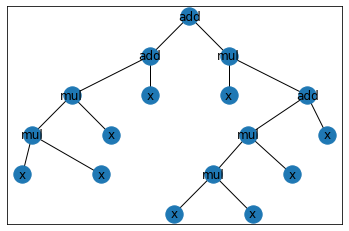

In [19]:
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [20]:
print(best)

add(add(mul(mul(x, x), x), x), mul(x, add(mul(mul(x, x), x), x)))


In [22]:
gp_func = toolbox.compile(expr=best)
def true_fc(x):
  return x**4 + x**3 + x**2 + x
error = gp_func(0.1) - true_fc(0.1)
print(error)

0.0


# Notes

DEAP: Evolutionary Algorithms Made Easy

https://www.jmlr.org/papers/volume13/fortin12a/fortin12a.pdf


TensorGP – Genetic Programming Engine in
TensorFlow

https://arxiv.org/pdf/2103.07512.pdf